 <span style ="color:blue ; font-size:20px ;font-weight:bold">(1)라이브러리 및 함수 데이터 불러오기------------------------------------------------------------------ </span>

In [665]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance, plot_tree

import numpy as np
import pandas as pd
import graphviz
from jbfg.pandas_utils import * 
import seaborn as sns
import matplotlib.pyplot as plt   #그래프 출력시
import matplotlib as mpl    #그래프 옵션
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

#그래프 시각화 옵션 설정함수
%matplotlib inline

#그래프의 한글설정
mpl.rc('font',family='Malgun Gothic')

#그래프의 한글을 더욱 선명하게 출력
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

#그래프에서 음수 값이 나올 때, 깨지는 현상 방지
mpl.rc('axes',unicode_minus=False)
#  sql 사용 

from pandasql import sqldf
pysqldf = lambda q: sqldf(q,globals())

In [666]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import math

In [667]:
#  sql 사용  SAS 사용자 익숙 
pysqldf = lambda q: sqldf(q,globals())

def index_projection(reference, x):#고객 및 상품 id를 나열하고 순서대로 번호를 매기는 함수
    reference_sort = np.unique(reference)
    index_reference_sort = np.where(reference_sort == x)[0]
    if len(index_reference_sort) != 0:
        return index_reference_sort[0] #Start with 0
    return None

def index_projection_inv(reference, ind):#순서대로 번호를 매긴 고객 및 상품 id를 다시 원래 id로 변환하는 함수
    reference_sort = np.unique(reference)
    return reference_sort[ind]

In [668]:
schema='l2_jbbk_extnl'

In [669]:
# 상품정보 테이블 
products_info_sql='SELECT * FROM products_info'

# 5,859명 고객들 과거 구매 이력  
train_x_past_sql='SELECT * FROM train_x_past'

# 5,859명 고객들 최근 주문성보
train_x_current_sql = 'SELECT * FROM train_x_current'  

# 5,859명 고객들 최근 주문상품(train_x_current 각 row에 매핑되는 상품정보)
train_y_sql = 'SELECT * FROM train_y'  

# 4,141명 고객들 과거 구매 이력  
test_x_past_sql='SELECT * FROM test_x_past'

# 4,141명 고객들 최근 주문성보
test_x_current_sql='SELECT * FROM test_x_current'

In [670]:
# 데이터 불러오기 
product_info = get_df(products_info_sql, schema) 

train_x_past = get_df(train_x_past_sql, schema) 
train_x_current = get_df(train_x_current_sql, schema)  
train_y = get_df(train_y_sql, schema) 

# 분석용데이터
test_x_past = get_df(test_x_past_sql, schema)  
test_x_current = get_df(test_x_current_sql, schema)  

In [671]:
# Order_id : 주문 id / cstno : 고객id / order_number : 고객별 주문서순번(구매일자별순번)  / week_day : 구매요일 / order_hour : 구매시각 
# / order_interbal : 직전구매경과일수 / add_order : 주문서내 담긴 상품의 순번 / is_reordered : 재구매여부 / product_id 상품id  
#product_in : 상품id / name : 상품명 / category_id 분류ID / division_id 담당부서아이디 / category_name 분류명 / division_name 담당부서명

In [672]:
product_info

,product_id,name,category_id,division_id,category_name,division_name
0,21709,Sparkling Lemon Water,115,7,water seltzer sparkling water,beverages
1,20995,Organic Broccoli Florets,116,1,frozen produce,frozen
2,33000,Pure Irish Butter,36,16,butter,dairy eggs
3,7781,Organic Sticks Low Moisture Part Skim Mozzarel...,21,16,packaged cheese,dairy eggs
4,47144,Unsweetened Original Almond Breeze Almond Milk,91,16,soy lactosefree,dairy eggs
...,...,...,...,...,...,...
95,47209,Organic Hass Avocado,24,4,fresh fruits,produce
96,21903,Organic Baby Spinach,123,4,packaged vegetables fruits,produce
97,21137,Organic Strawberries,24,4,fresh fruits,produce
98,13176,Bag of Organic Bananas,24,4,fresh fruits,produce


In [673]:
train_x_current

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered
0,806422,41116,47,5,18,3.0,4,1
1,2146033,127113,45,1,10,7.0,24,1
2,3055498,140168,45,5,10,26.0,11,1
3,3267527,60604,52,0,16,8.0,2,1
4,3125992,136554,46,4,9,5.0,2,0
...,...,...,...,...,...,...,...,...
24419,3184000,174046,100,5,7,2.0,12,1
24420,1754722,6710,100,5,11,3.0,21,1
24421,1076973,150840,100,0,13,0.0,18,1
24422,1247049,99707,100,1,13,3.0,6,1


 <span style ="color:blue ; font-size:20px ;font-weight:bold">(2)데이터 확인 및 점검------------------------------------------------------------------ </span>

In [674]:
# 결측치 확인 
print("★products_info 결측치확인:\n",product_info.isnull().sum())
print("★train_x_past 결측치확인:\n",train_x_past.isnull().sum())
print("★train_x_current 결측치확인:\n",train_x_current.isnull().sum())
print("★train_y 결측치확인:\n",train_y.isnull().sum())

★products_info 결측치확인:
 product_id       0
name             0
category_id      0
division_id      0
category_name    0
division_name    0
dtype: int64
★train_x_past 결측치확인:
 order_id          0
cstno             0
order_number      0
week_day          0
order_hour        0
order_interval    0
add_order         0
is_reordered      0
product_id        0
dtype: int64
★train_x_current 결측치확인:
 order_id          0
cstno             0
order_number      0
week_day          0
order_hour        0
order_interval    0
add_order         0
is_reordered      0
dtype: int64
★train_y 결측치확인:
 product_id    0
dtype: int64


In [675]:
pysqldf("""
select category_name,count(*) from product_info group by 1
""")


,category_name,count(*)
0,bread,1
1,butter,2
2,canned meals beans,1
3,cream,2
4,eggs,2
5,fresh dips tapenades,1
6,fresh fruits,24
7,fresh herbs,3
8,fresh vegetables,29
9,frozen produce,2


In [676]:
# train_x_past에 대한 정보 호출
train_x_past.info() 

#order_interval에 null값이 존재하는 raw 추출
null_order_interval = train_x_past[['order_id','cstno','order_interval','add_order']].loc[train_x_past['order_interval'].isnull() == True]

#추출한 정보 확인
null_order_interval.head(10)

#null값의 경우 첫주문으로 보고 first_order 생성
null_order_interval['first_order'] = 1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253972 entries, 0 to 1253971
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   order_id        1253972 non-null  object
 1   cstno           1253972 non-null  object
 2   order_number    1253972 non-null  object
 3   week_day        1253972 non-null  object
 4   order_hour      1253972 non-null  object
 5   order_interval  1253972 non-null  object
 6   add_order       1253972 non-null  object
 7   is_reordered    1253972 non-null  object
 8   product_id      1253972 non-null  object
dtypes: object(9)
memory usage: 86.1+ MB


In [677]:
train_x_current.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24424 entries, 0 to 24423
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   order_id        24424 non-null  object
 1   cstno           24424 non-null  object
 2   order_number    24424 non-null  object
 3   week_day        24424 non-null  object
 4   order_hour      24424 non-null  object
 5   order_interval  24424 non-null  object
 6   add_order       24424 non-null  object
 7   is_reordered    24424 non-null  object
dtypes: object(8)
memory usage: 1.5+ MB


In [678]:
#train_x_past에 null_order_interval을 결합(order_id, cstno, add_order key 값으로 활용)
train_x_past = pd.merge(left = train_x_past, right = null_order_interval, how = 'left', on = ['order_id','cstno','add_order'])
#train_x_past에 존재하는 order_interval을 0으로 변환
train_x_past['order_interval_x'].fillna(0, inplace = True) 
#첫주문이 아닌 first_order에 0에 값을 부여
train_x_past['first_order'].fillna(0, inplace = True)

In [679]:
train_x_past.drop('order_interval_y',axis=1,inplace=True) #order_interval_y 칼럼 삭제
train_x_past.rename(columns = {'order_interval_x':'order_interval'}, inplace = True) # 칼럼명 재정의
train_x_past

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,first_order
0,717029,196613,15,1,9,3.0,5,0,41220,0.0
1,2325772,196613,35,6,11,2.0,7,1,41220,0.0
2,642668,196613,69,2,16,2.0,11,1,4210,0.0
3,1326515,196613,61,3,19,3.0,3,1,4210,0.0
4,1437845,196613,36,3,15,4.0,16,0,4210,0.0
...,...,...,...,...,...,...,...,...,...,...
1253967,1902783,163819,47,0,19,13.0,2,1,24852,0.0
1253968,1969590,163819,42,1,15,6.0,3,1,24852,0.0
1253969,2549215,163819,9,1,11,7.0,1,1,24852,0.0
1253970,3103211,163819,39,1,14,7.0,3,1,24852,0.0


In [680]:
#null값 처리 완료
train_x_past.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1253972 entries, 0 to 1253971
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   order_id        1253972 non-null  object 
 1   cstno           1253972 non-null  object 
 2   order_number    1253972 non-null  object 
 3   week_day        1253972 non-null  object 
 4   order_hour      1253972 non-null  object 
 5   order_interval  1253972 non-null  object 
 6   add_order       1253972 non-null  object 
 7   is_reordered    1253972 non-null  object 
 8   product_id      1253972 non-null  object 
 9   first_order     1253972 non-null  float64
dtypes: float64(1), object(9)
memory usage: 105.2+ MB


In [681]:
#order_interval에 null값이 존재하는 raw 추출
null_order_interval = train_x_current[['order_id','cstno','order_interval','add_order']].loc[train_x_current['order_interval'].isnull() == True]

#null값의 경우 첫주문으로 보고 first_order 생성
null_order_interval['first_order'] = 1

#train_x_past에 null_order_interval을 결합(order_id, cstno, add_order key 값으로 활용)
train_x_current = pd.merge(left = train_x_current, right = null_order_interval, how = 'left', on = ['order_id','cstno','add_order'])

#train_x_past에 존재하는 order_interval을 0으로 변환
train_x_current['order_interval_x'].fillna(0, inplace = True)

#첫주문이 아닌 first_order에 0에 값을 부여
train_x_current['first_order'].fillna(0, inplace = True)

In [682]:
train_x_current.drop('order_interval_y',axis=1,inplace=True)
train_x_current.rename(columns = {'order_interval_x':'order_interval'}, inplace = True)
train_x_current


,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,first_order
0,806422,41116,47,5,18,3.0,4,1,0.0
1,2146033,127113,45,1,10,7.0,24,1,0.0
2,3055498,140168,45,5,10,26.0,11,1,0.0
3,3267527,60604,52,0,16,8.0,2,1,0.0
4,3125992,136554,46,4,9,5.0,2,0,0.0
...,...,...,...,...,...,...,...,...,...
24419,3184000,174046,100,5,7,2.0,12,1,0.0
24420,1754722,6710,100,5,11,3.0,21,1,0.0
24421,1076973,150840,100,0,13,0.0,18,1,0.0
24422,1247049,99707,100,1,13,3.0,6,1,0.0


In [683]:
train_x_past.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1253972 entries, 0 to 1253971
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   order_id        1253972 non-null  object 
 1   cstno           1253972 non-null  object 
 2   order_number    1253972 non-null  object 
 3   week_day        1253972 non-null  object 
 4   order_hour      1253972 non-null  object 
 5   order_interval  1253972 non-null  object 
 6   add_order       1253972 non-null  object 
 7   is_reordered    1253972 non-null  object 
 8   product_id      1253972 non-null  object 
 9   first_order     1253972 non-null  float64
dtypes: float64(1), object(9)
memory usage: 105.2+ MB


In [684]:
train_x_past['order_interval'].unique()
train_x_past['order_interval']=train_x_past['order_interval'].str.replace('','0')

In [685]:

# 모델링 진행을 위한 데이터 타입 변환
train_x_past[['cstno','order_hour','order_number','week_day','order_hour','add_order','is_reordered']]=train_x_past[['cstno','order_hour','order_number','week_day','order_hour','add_order','is_reordered']].astype('int')
train_x_current[['cstno','order_hour','order_number','week_day','order_hour','add_order','is_reordered']]=train_x_current[['cstno','order_hour','order_number','week_day','order_hour','add_order','is_reordered']].astype('int')

train_x_past['order_interval']=train_x_past[['order_interval']].astype('float')
train_x_current['order_interval']=train_x_current[['order_interval']].astype('float')


In [686]:

#모델링을 진행가 위한 데이터 tpye변환
train_x_past[['order_hour','order_interval','add_order','is_reordered']] = train_x_past[['order_hour','order_interval','add_order','is_reordered']].astype('int')
train_x_current[['order_hour','order_interval','add_order','is_reordered']] = train_x_current[['order_hour','order_interval','add_order','is_reordered']].astype('int')


 <span style ="color:blue ; font-size:20px ;font-weight:bold">(3)시각화 및 자료 분석 ------------------------------------------------------------------ </span>

In [687]:
train_x_past_info = pd.merge(left = train_x_past, right = product_info, how = 'left', on = 'product_id')
train_x_past_info.head(10)

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,first_order,name,category_id,division_id,category_name,division_name
0,717029,196613,15,1,9,30,5,0,41220,0.0,Organic Romaine Lettuce,83,4,fresh vegetables,produce
1,2325772,196613,35,6,11,20,7,1,41220,0.0,Organic Romaine Lettuce,83,4,fresh vegetables,produce
2,642668,196613,69,2,16,20,11,1,4210,0.0,Whole Milk,84,16,milk,dairy eggs
3,1326515,196613,61,3,19,30,3,1,4210,0.0,Whole Milk,84,16,milk,dairy eggs
4,1437845,196613,36,3,15,40,16,0,4210,0.0,Whole Milk,84,16,milk,dairy eggs
5,185079,196613,94,6,17,60,1,1,38689,0.0,Organic Reduced Fat Milk,84,16,milk,dairy eggs
6,358293,196613,93,0,11,40,1,1,38689,0.0,Organic Reduced Fat Milk,84,16,milk,dairy eggs
7,539821,196613,50,6,15,40,13,1,38689,0.0,Organic Reduced Fat Milk,84,16,milk,dairy eggs
8,642668,196613,69,2,16,20,15,1,38689,0.0,Organic Reduced Fat Milk,84,16,milk,dairy eggs
9,696513,196613,66,3,21,0,2,1,38689,0.0,Organic Reduced Fat Milk,84,16,milk,dairy eggs


Text(0.5, 1.0, 'product_cnt')

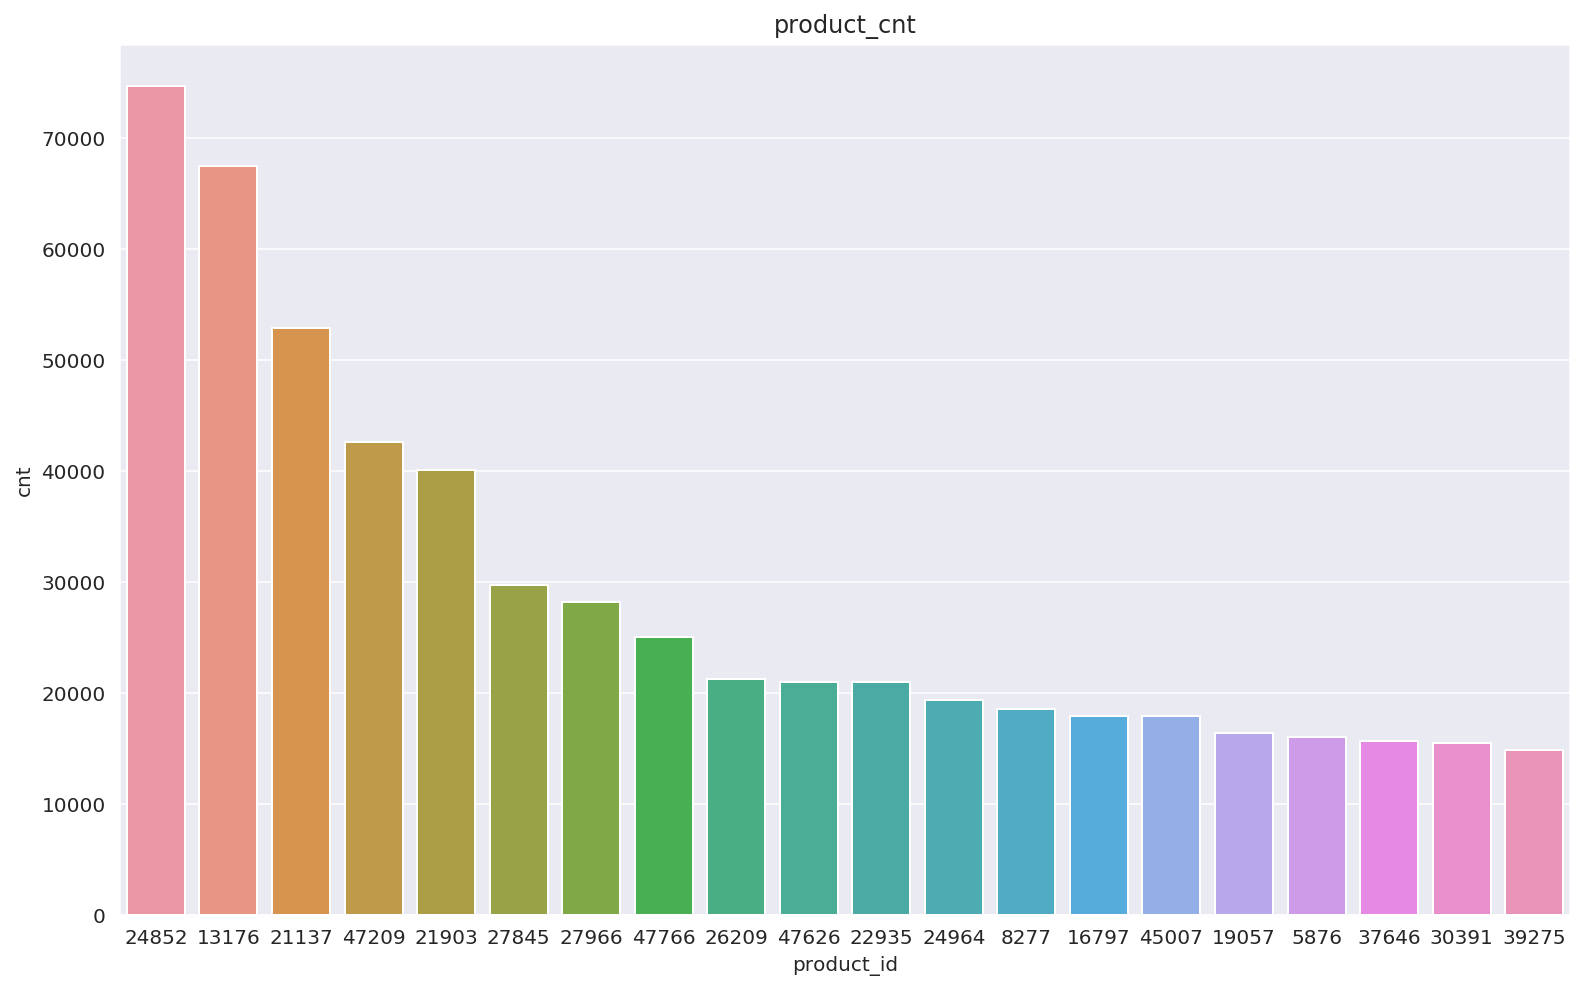

In [688]:
#상품구매 빈도수
product_cnt = train_x_past_info[['product_id',"name"]].value_counts(ascending = False, sort = True)
product_cnt = product_cnt.reset_index()
product_cnt.rename(columns = {0:'cnt'},inplace=True)
product_cnt['product_id'] = product_cnt['product_id'].astype('string')
#상품 구매 빈도수 상위 10개 시각화
plt.figure(figsize=[13,8])
p = sns.barplot(data=product_cnt.head(20),x='product_id',y='cnt')
p.set_title('product_cnt')

In [689]:
#요일별 구매 빈도수
weekday_cnt = train_x_past_info[["week_day",'category_name']].value_counts(ascending = False, sort = True)  #빈도수 확인
weekday_cnt = weekday_cnt.reset_index()
weekday_cnt.rename(columns = {0:'cnt'},inplace=True)
weekday_cnt
 

,week_day,category_name,cnt
0,0,fresh fruits,90658
1,1,fresh fruits,90321
2,5,fresh fruits,71453
3,6,fresh fruits,65218
4,2,fresh fruits,63331
...,...,...,...
142,2,soft drinks,472
143,3,soft drinks,431
144,4,soft drinks,423
145,0,soft drinks,89


In [690]:
#요일별  시간별 구매 빈도수
weekday_h_cnt = train_x_past_info[["week_day",'order_hour']].value_counts(ascending = False, sort = True)  #빈도수 확인
weekday_h_cnt = weekday_h_cnt.reset_index()
weekday_h_cnt.rename(columns = {0:'cnt'},inplace=True)
weekday_h_cnt
 

,week_day,order_hour,cnt
0,1,10,24045
1,1,9,23229
2,0,14,20047
3,1,11,20044
4,0,13,19567
...,...,...,...
163,2,3,213
164,4,4,206
165,6,3,201
166,4,3,178


In [691]:
weekday_h_cnt.dtypes

week_day      int64
order_hour    int64
cnt           int64
dtype: object

In [692]:
pysqldf("""
select * from weekday_h_cnt  where week_day=0
order by 2
""")
#  요일과시간대별 

,week_day,order_hour,cnt
0,0,0,1459
1,0,1,779
2,0,2,362
3,0,3,307
4,0,4,352
5,0,5,486
6,0,6,1709
7,0,7,7015
8,0,8,14593
9,0,9,19222


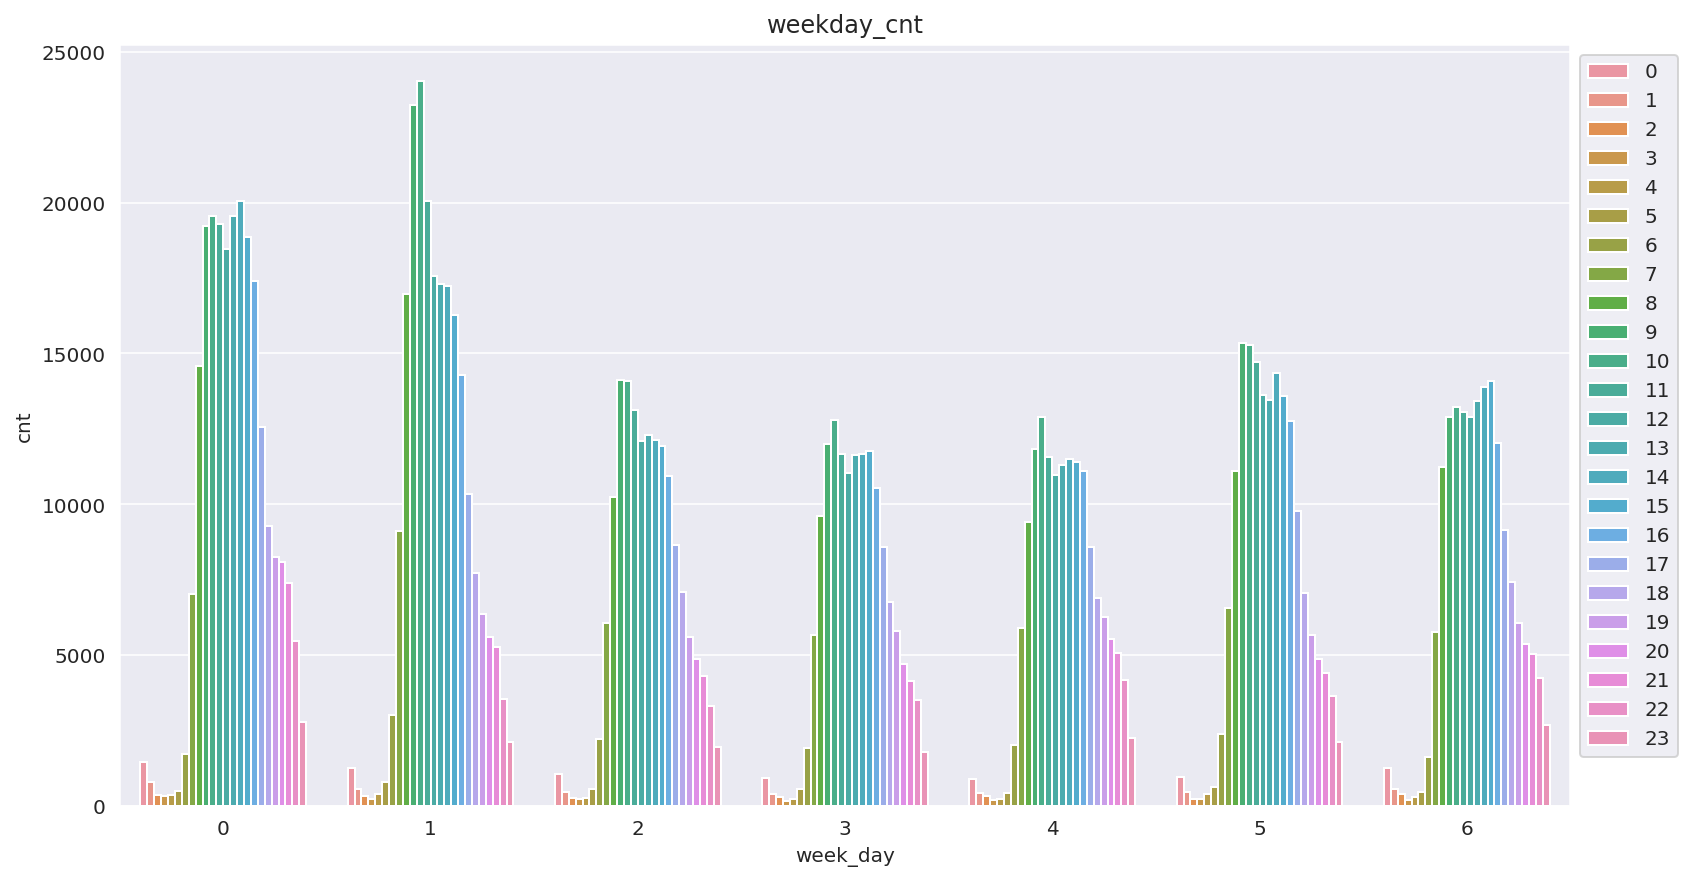

In [693]:
# 요일별 구매 빈도수 시각화
plt.figure(figsize=[13,7])
p = sns.barplot( data = weekday_h_cnt,x = 'week_day', y= 'cnt', hue = 'order_hour')
p.set_title('weekday_cnt')
plt.legend(loc = 2, bbox_to_anchor = (1,1))
plt.show()

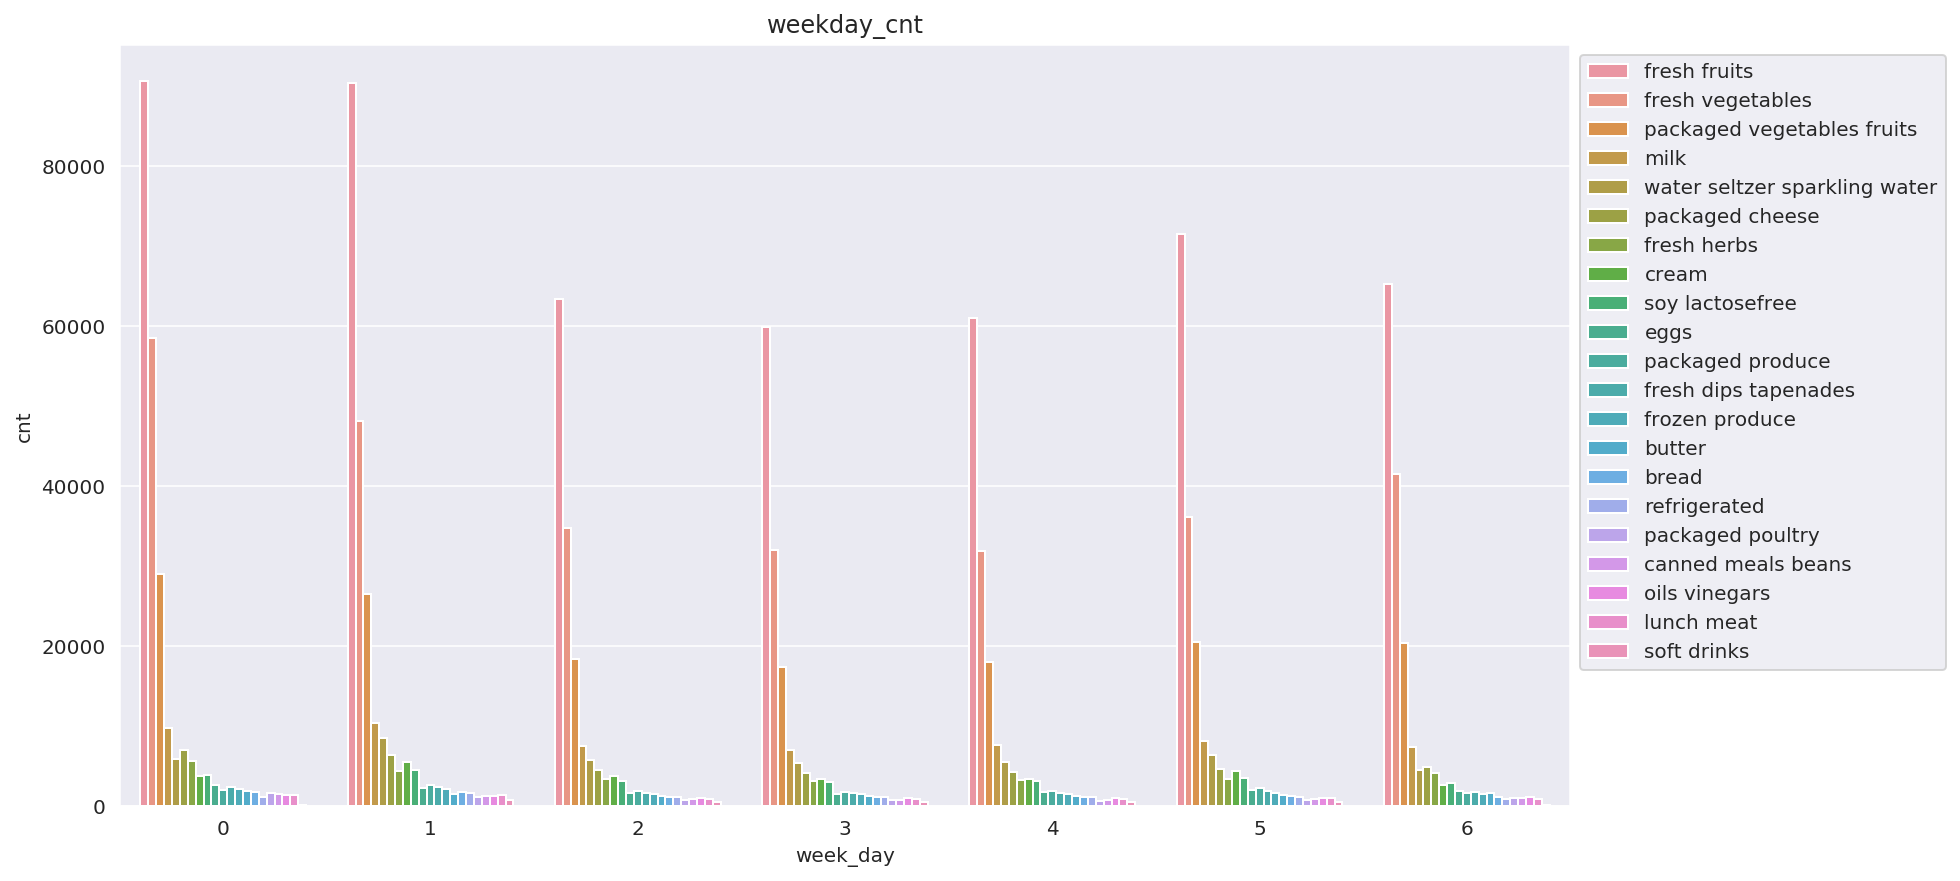

In [694]:
# 요일별 구매 빈도수 시각화
plt.figure(figsize=[13,7])
p = sns.barplot( data = weekday_cnt,x = 'week_day', y= 'cnt', hue = 'category_name')
p.set_title('weekday_cnt')
plt.legend(loc = 2, bbox_to_anchor = (1,1))
plt.show()

In [695]:
#구매 시간대별 빈도수
order_hour_cnt = train_x_past_info[["order_hour",'category_name']].value_counts(ascending = False, sort = True) #빈도수 확인
order_hour_cnt = order_hour_cnt.reset_index()
order_hour_cnt.rename(columns = {0:'cnt'},inplace=True)
order_hour_cnt

,order_hour,category_name,cnt
0,10,fresh fruits,45018
1,9,fresh fruits,44298
2,11,fresh fruits,41260
3,14,fresh fruits,39830
4,13,fresh fruits,39184
...,...,...,...
499,1,soft drinks,3
500,5,soft drinks,2
501,4,soft drinks,1
502,3,soft drinks,1


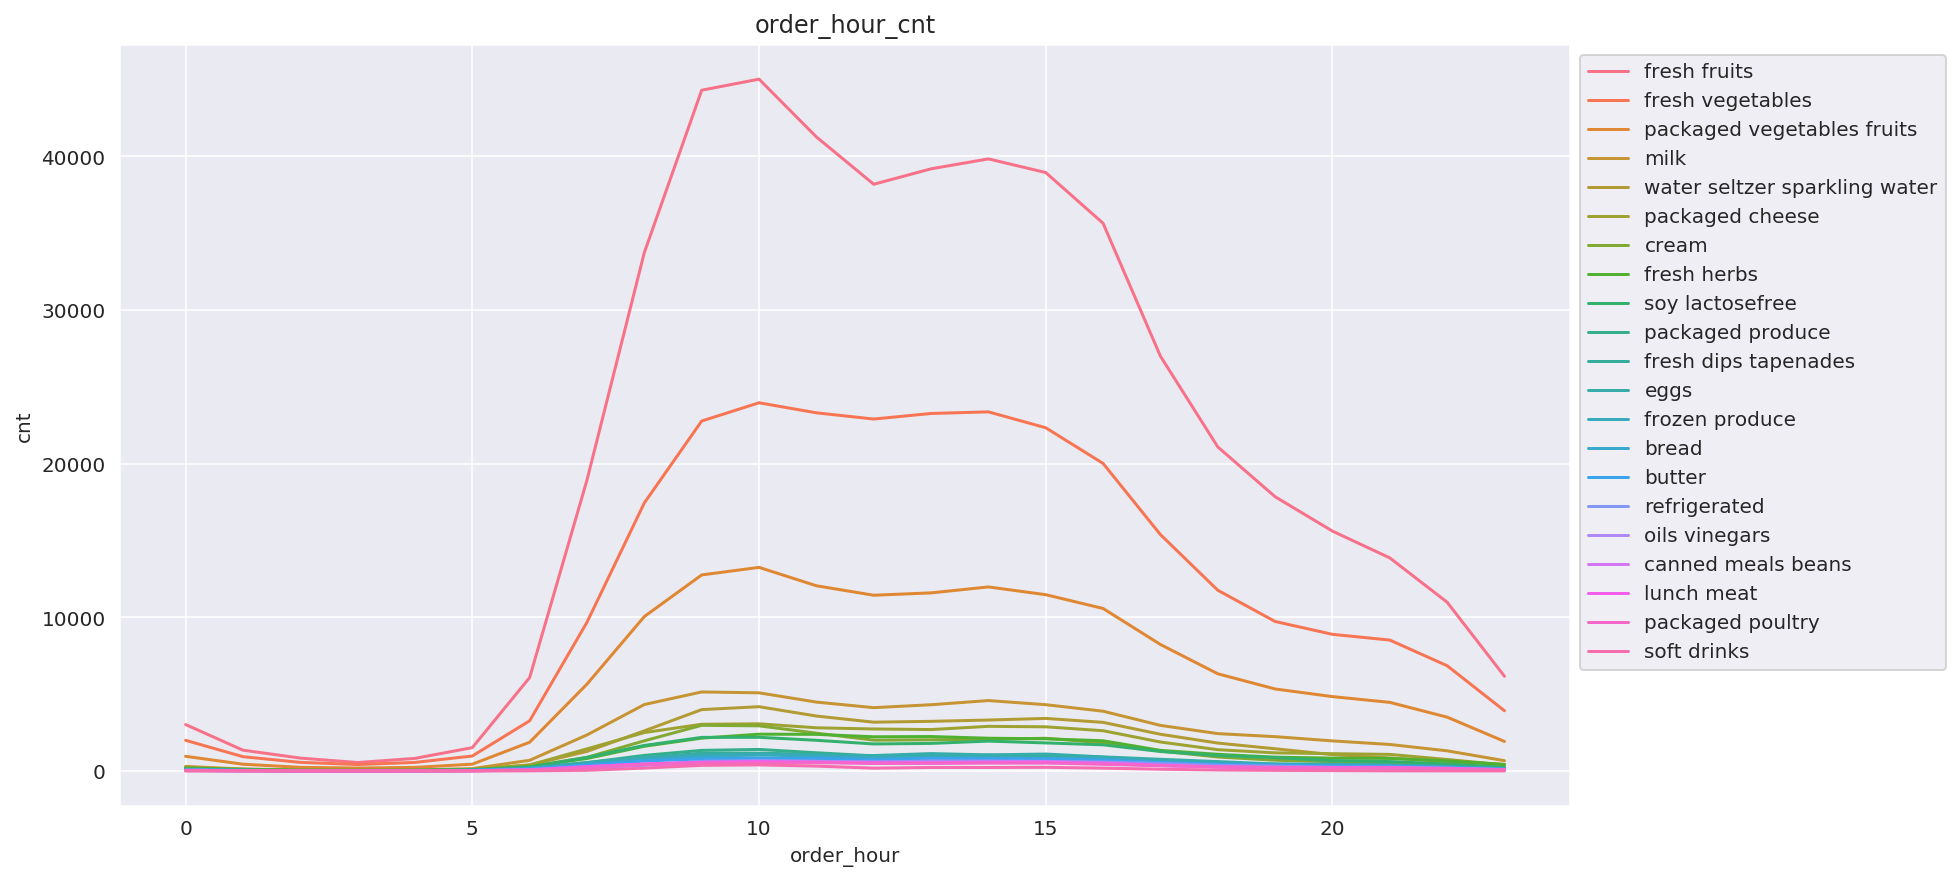

In [696]:
# 구매 시간대별 시각화
plt.figure(figsize=[13,7])
p = sns.lineplot( data = order_hour_cnt,x = 'order_hour', y= 'cnt', hue = 'category_name')
p.set_title('order_hour_cnt')
plt.legend(loc = 2, bbox_to_anchor = (1,1))
plt.show()

In [697]:
#상관계수 도출
corr_df = train_x_past.corr()
corr_df = corr_df.apply(lambda x: round(x ,2)) #소수점 둘째자리까지 표출
corr_df

,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,first_order
cstno,1.00,0.01,-0.00,-0.00,-0.00,0.01,0.00,NaN
order_number,0.01,1.00,0.01,-0.02,-0.10,-0.02,0.25,NaN
week_day,-0.00,0.01,1.00,0.02,-0.02,-0.01,0.00,NaN
order_hour,-0.00,-0.02,0.02,1.00,-0.02,-0.01,-0.01,NaN
order_interval,-0.00,-0.10,-0.02,-0.02,1.00,0.06,-0.01,NaN
add_order,0.01,-0.02,-0.01,-0.01,0.06,1.00,-0.10,NaN
is_reordered,0.00,0.25,0.00,-0.01,-0.01,-0.10,1.00,NaN
first_order,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


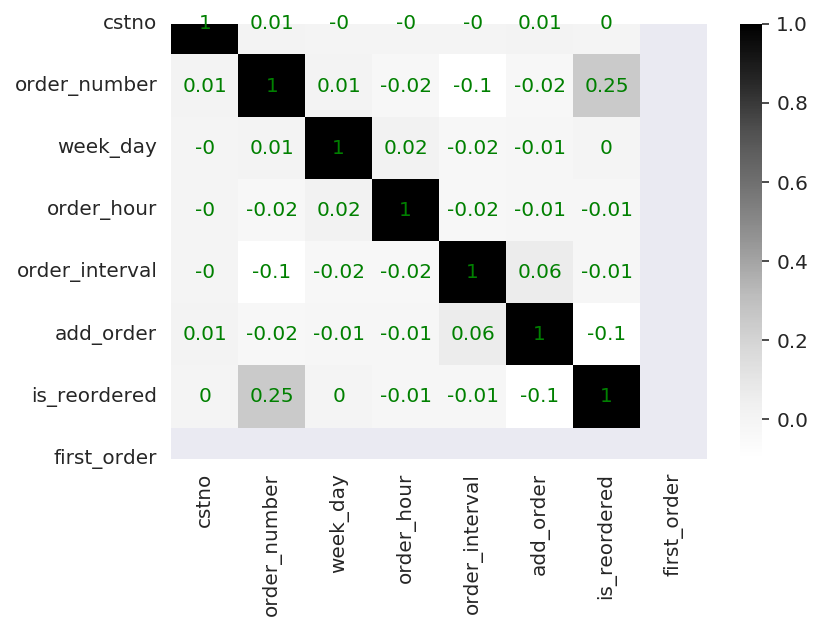

In [698]:
#상관계수에 대한 시각화
ax = sns.heatmap(corr_df, annot=True, annot_kws=dict(color='g'), cmap='Greys')
plt.show()

In [699]:
#평균 재구매 기간
train_x_past['order_interval'].mean()

178.90094834653405

Text(0.5, 1.0, 'Order_Interval_Mean')

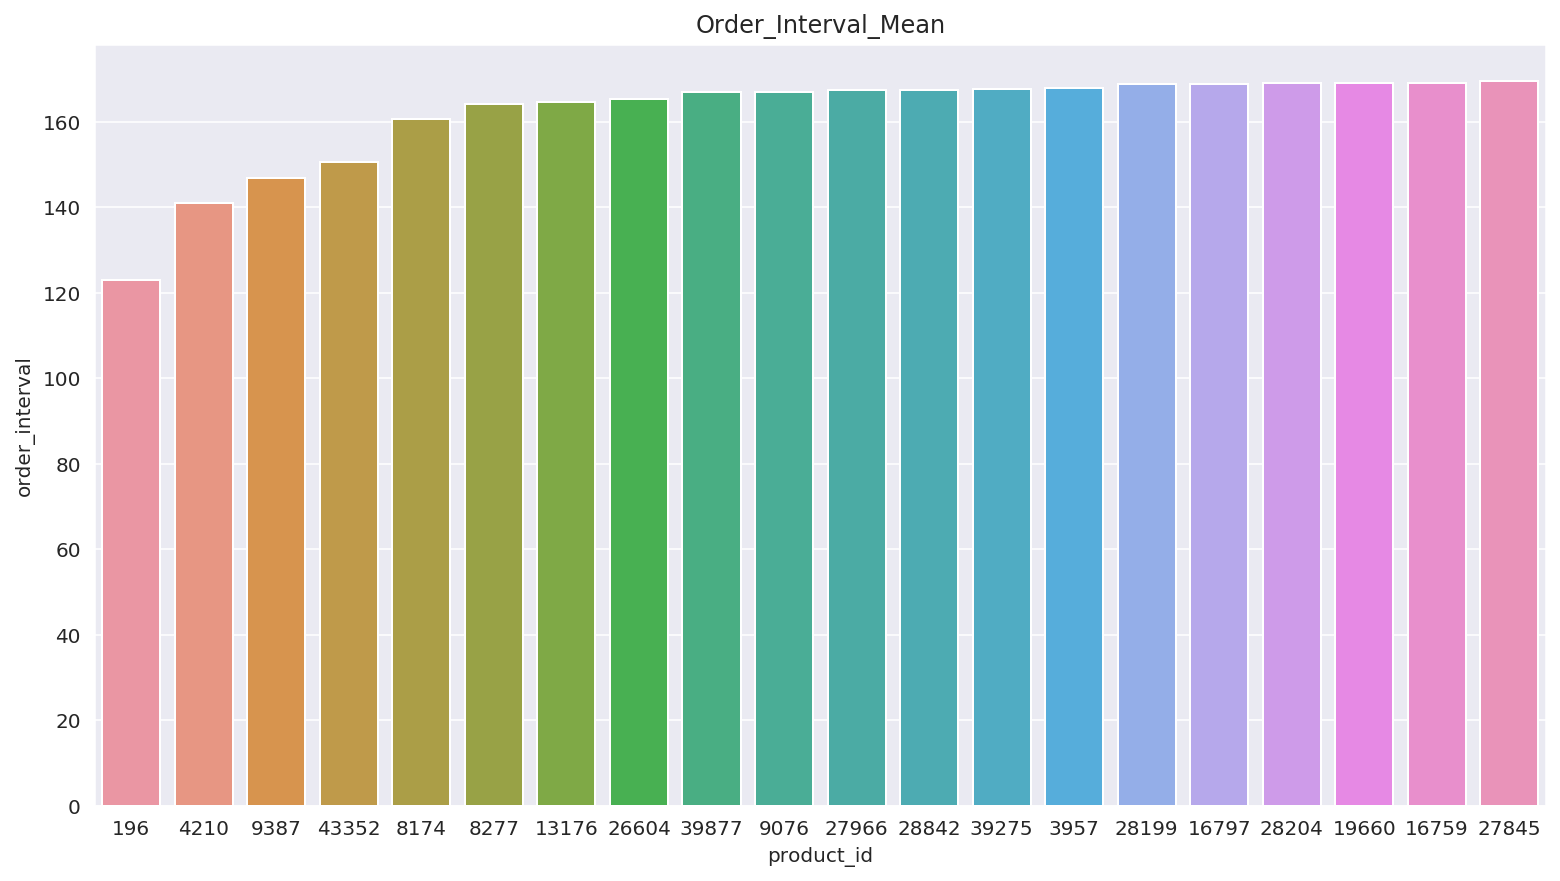

In [700]:
#상품별 재구매에 걸리는 평균 기간
df_train_x_past = train_x_past[['product_id','order_interval']]
df_train_x_past['product_id'] = df_train_x_past['product_id'].astype('string')
df_train_x_past = df_train_x_past.groupby('product_id',as_index=False).mean().sort_values(by='order_interval',ascending=True,ignore_index = True)
plt.figure(figsize=[13,7])
#재구매 평균기간 상위 20개  추출
p = sns.barplot(data=df_train_x_past.head(20),x='product_id',y='order_interval')
p.set_title('Order_Interval_Mean')
#재구매 평균 구매기간이 짧은 상품일수록 자주 구매할 확률이 올라간다.
#order_interval_ratio 변수를 생성하여 예측 모델의 변수로 활용 (뒤)

In [701]:
#고객별 재구매 상품 비율
df_pd_reordered = pd.DataFrame(train_x_past_info.groupby(['cstno', 'name','product_id'])['is_reordered'].sum()) # 고객별, 상품별 재구매 횟수
df_cn_reordered = pd.DataFrame(train_x_past_info.groupby(['cstno'])['is_reordered'].sum()) # 고객별 재구매 횟수
df_pd_reordered.reset_index()
df_cn_reordered.reset_index()

df_pd_reordered['is_reordered_ratio'] = df_pd_reordered['is_reordered'] / df_cn_reordered['is_reordered']# 고객별 상품에 대한 재구매 비율
df_pd_reordered = df_pd_reordered.reset_index().sort_values(by='is_reordered_ratio',ascending=False,ignore_index = True) # 내림차순으로 정렬
df_pd_reordered[['cstno','product_id']] = df_pd_reordered[['cstno','product_id']].astype('string') # 고객과 상품을 문자타입으로 변경
#고객별 재구매 상품 비율 시각화
df_pd_reordered.head(20).style.background_gradient(cmap='viridis')
#  고객이 특정 상품에 대한 재구매가 높은지를 확인하는 작업으로 높은 항목에 대해 분석모형에서 가중치를 적용할 예정


,cstno,name,product_id,is_reordered,is_reordered_ratio
0,197745,Whole Milk,4210,67,1.000000
1,15182,Whole Milk,4210,74,1.000000
2,16883,Organic Fuji Apple,28204,41,1.000000
3,84627,Unsweetened Original Almond Breeze Almond Milk,47144,52,1.000000
4,199091,Soda,196,68,1.000000
5,131805,Sparkling Water Grapefruit,44632,66,1.000000
6,98091,2% Reduced Fat Milk,23909,47,1.000000
7,133105,Organic Reduced Fat 2% Milk,5785,48,1.000000
8,74884,Whole Milk,4210,60,1.000000
9,194567,2% Reduced Fat Milk,23909,59,1.000000


In [704]:
df_pd_reordered['is_reordered_ratio'].unique()

array([1.        , 0.98850575, 0.97959184, ..., 0.0013459 , 0.00134228,
       0.        ])

In [705]:
#고객에대한 확률 ? 
cstno_rt=pysqldf("""
select cstno , avg(is_reordered_ratio) as is_reordered_ratio_avg from df_pd_reordered  group by 1
order by 2 
""")

 <span style ="color:blue ; font-size:20px ;font-weight:bold">(3-1)군집화------------------------------------------------------------------ </span>

In [706]:
#고객의 주문 특성에 따른 군집 분석
df_order_cnt = train_x_past[['order_id','cstno','order_number','add_order']]

#한번 주문할때 고객의 주문횟수
order_cnt = df_order_cnt.groupby(['order_id', 'cstno'])['add_order'].count()
order_cnt = order_cnt.reset_index()
order_cnt.rename(columns = {'add_order':'order_cnt'},inplace=True)
order_cnt

#고객의 평균 주문횟수
order_mean = order_cnt.groupby(['cstno'])['order_cnt'].mean()
order_mean = order_mean.reset_index()
order_mean.rename(columns = {'order_cnt':'order_mean'},inplace=True)
order_mean

#추가 변수를 train_x_past 테이블에 결합
train_x_past = pd.merge(left = train_x_past, right = order_cnt, how = 'left', on = ['order_id','cstno'])
train_x_past = pd.merge(left = train_x_past, right = order_mean, how = 'left', on = ['cstno'])
train_x_past

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,first_order,order_cnt,order_mean
0,717029,196613,15,1,9,30,5,0,41220,0.0,2,2.900000
1,2325772,196613,35,6,11,20,7,1,41220,0.0,3,2.900000
2,642668,196613,69,2,16,20,11,1,4210,0.0,5,2.900000
3,1326515,196613,61,3,19,30,3,1,4210,0.0,2,2.900000
4,1437845,196613,36,3,15,40,16,0,4210,0.0,3,2.900000
...,...,...,...,...,...,...,...,...,...,...,...,...
1253967,1902783,163819,47,0,19,1030,2,1,24852,0.0,8,4.191489
1253968,1969590,163819,42,1,15,60,3,1,24852,0.0,4,4.191489
1253969,2549215,163819,9,1,11,70,1,1,24852,0.0,5,4.191489
1253970,3103211,163819,39,1,14,70,3,1,24852,0.0,3,4.191489


In [707]:
#군집 분석을 위한 함수 설정
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화 
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    

    try:
        # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
        n_cols = len(cluster_lists)
        fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

        # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
        pca = PCA(n_components=2)
        pca_transformed = pca.fit_transform(X_features)
        dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])

         # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
        for ind, n_cluster in enumerate(cluster_lists):

            # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
            clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
            cluster_labels = clusterer.fit_predict(pca_transformed)
            dataframe['cluster']=cluster_labels

            unique_labels = np.unique(clusterer.labels_)
            markers=['o', 's', '^', 'x', '*']

            # 클러스터링 결과값 별로 scatter plot 으로 시각화
            for label in unique_labels:
                label_df = dataframe[dataframe['cluster']==label]
                if label == -1:
                    cluster_legend = 'Noise'
                else :
                    cluster_legend = 'Cluster '+str(label)           
                axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                            edgecolor='k', marker=markers[label], label=cluster_legend)

            axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
            axs[ind].legend(loc='upper right')

        plt.show()
        
    except Exception as e :
        pass

In [708]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 
    

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")


In [709]:

#첫번째 주문, 주문 간격, 주문횟수, 평균 주문횟수를 가지고 고객의 군집을 파악
cluster_set = pd.pivot_table(data= train_x_past, index = ['cstno'], values = ['first_order','order_interval','order_cnt','order_mean']
                              ,aggfunc='mean').reset_index()

dtot = cluster_set.drop('cstno',axis=1)

#변수에 대한 표준화 작업

sc = StandardScaler()
sc_clust = sc.fit_transform(dtot)
sc_clust = pd.DataFrame(sc_clust)

In [710]:
#null값 처리 완료
train_x_past.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1253972 entries, 0 to 1253971
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   order_id        1253972 non-null  object 
 1   cstno           1253972 non-null  int64  
 2   order_number    1253972 non-null  int64  
 3   week_day        1253972 non-null  int64  
 4   order_hour      1253972 non-null  int64  
 5   order_interval  1253972 non-null  int64  
 6   add_order       1253972 non-null  int64  
 7   is_reordered    1253972 non-null  int64  
 8   product_id      1253972 non-null  object 
 9   first_order     1253972 non-null  float64
 10  order_cnt       1253972 non-null  int64  
 11  order_mean      1253972 non-null  float64
dtypes: float64(2), int64(8), object(2)
memory usage: 124.4+ MB


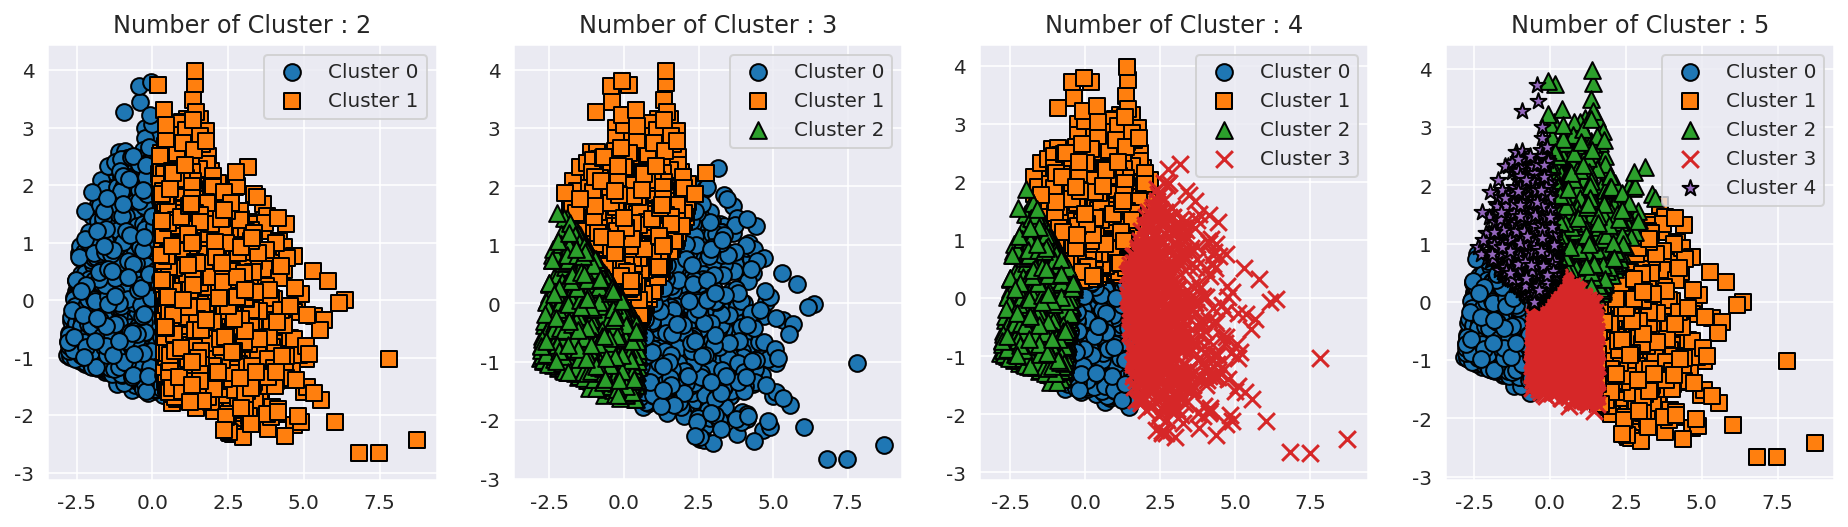

In [711]:
#군집 2,3,4,5, 에대한 시각화 표현
visualize_kmeans_plot_multi([2,3,4,5],sc_clust)


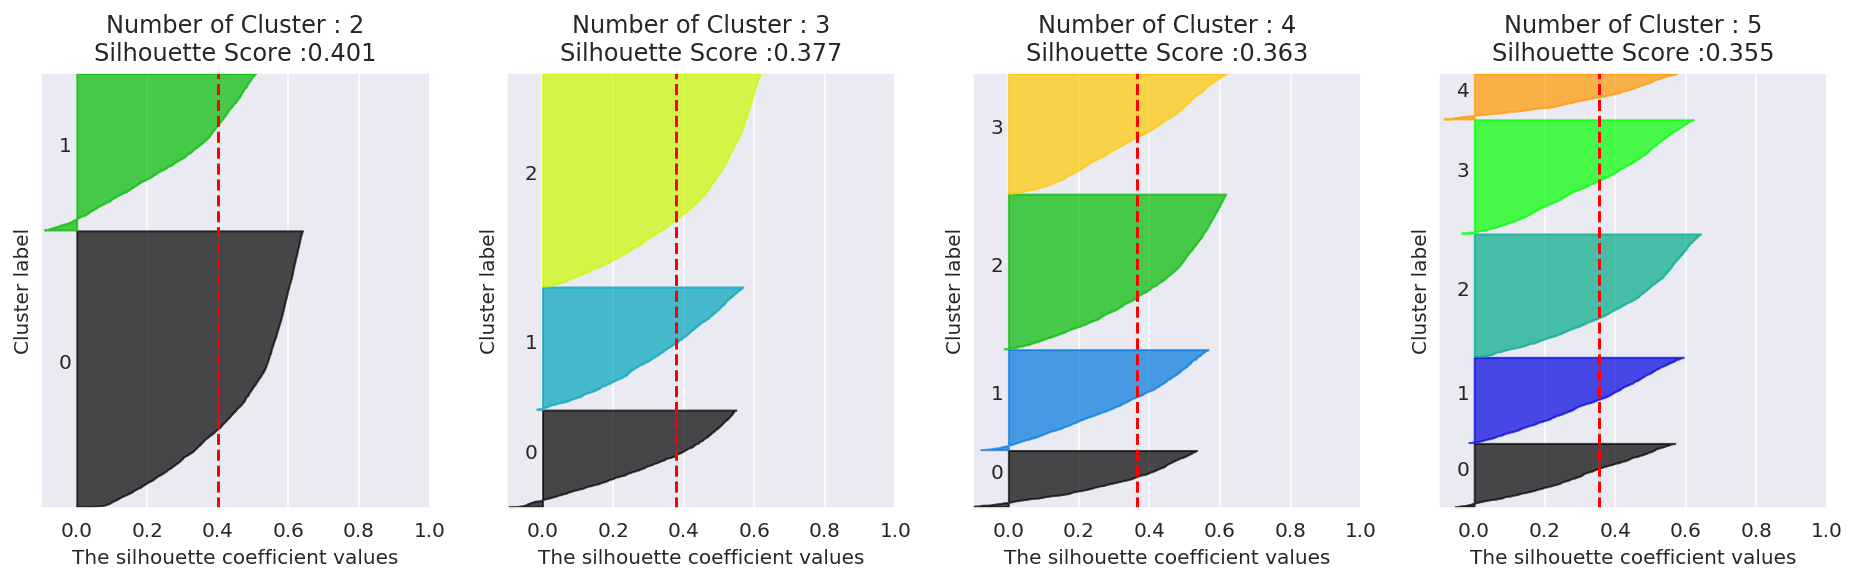

In [712]:
#최적의 군집을 찾기위한 실루엣 검증 (높을수록 좋은 군집)
visualize_silhouette([2,3,4,5],sc_clust)


In [713]:
#n_clusters는 위의 검증결과를 반영하여 설정
model=KMeans(n_clusters=2,max_iter=150,init='k-means++')

In [714]:
model.fit(sc_clust)

KMeans(max_iter=150, n_clusters=2)

In [715]:
cluster_set['cluster']=model.fit_predict(sc_clust)

In [716]:
cluster_set = cluster_set.drop(labels=['order_cnt','order_mean','first_order','order_interval'], axis = 1)

In [717]:
train_x_past = pd.merge(left = train_x_past, right = cluster_set, how = 'left', on = ['cstno'])

In [718]:
train_x_past

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,first_order,order_cnt,order_mean,cluster
0,717029,196613,15,1,9,30,5,0,41220,0.0,2,2.900000,0
1,2325772,196613,35,6,11,20,7,1,41220,0.0,3,2.900000,0
2,642668,196613,69,2,16,20,11,1,4210,0.0,5,2.900000,0
3,1326515,196613,61,3,19,30,3,1,4210,0.0,2,2.900000,0
4,1437845,196613,36,3,15,40,16,0,4210,0.0,3,2.900000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253967,1902783,163819,47,0,19,1030,2,1,24852,0.0,8,4.191489,1
1253968,1969590,163819,42,1,15,60,3,1,24852,0.0,4,4.191489,1
1253969,2549215,163819,9,1,11,70,1,1,24852,0.0,5,4.191489,1
1253970,3103211,163819,39,1,14,70,3,1,24852,0.0,3,4.191489,1


In [719]:
train_x_current = pd.merge(left = train_x_current, right = cluster_set, how = 'left', on = ['cstno'])

In [720]:
train_x_current

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,first_order,cluster
0,806422,41116,47,5,18,3,4,1,0.0,0
1,2146033,127113,45,1,10,7,24,1,0.0,0
2,3055498,140168,45,5,10,26,11,1,0.0,0
3,3267527,60604,52,0,16,8,2,1,0.0,0
4,3125992,136554,46,4,9,5,2,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
24419,3184000,174046,100,5,7,2,12,1,0.0,1
24420,1754722,6710,100,5,11,3,21,1,0.0,1
24421,1076973,150840,100,0,13,0,18,1,0.0,1
24422,1247049,99707,100,1,13,3,6,1,0.0,0


 <span style ="color:blue ; font-size:20px ;font-weight:bold">(4)데이터 전처리 및 가변수 생성------------------------------------------------------------------ </span>

In [731]:
#필요 컬럼 정의
col1 = ['week_day','order_hour','order_interval','add_order','is_reordered','cluster'] #  cstno 제외 전처리 
col2 = ['cstno', 'week_day','order_hour','order_interval','add_order','is_reordered','cluster'] # 모든 변수 포함 전처리


In [732]:
#test1 (cstno를 제외한 모든 변수)
x_train1 = train_x_past[col1]
y_train1 = train_x_past['product_id']
x_test1 = train_x_current[col1]
y_test1 = train_y['product_id']
 

In [733]:
#test2 (모든 변수를 활용하고 weekday를  가변수로 변환)
x_train2 = train_x_past[col2]
y_train2 = train_x_past['product_id']
x_test2 = train_x_current[col2]
y_test2 = train_y['product_id']


In [734]:
#test3(모든 변수를 활용하고 cluster를  가변수로 변환
x_train3 = train_x_past[col2]
y_train3 = train_x_past['product_id']
x_test3 = train_x_current[col2]
y_test3 = train_y['product_id']

In [599]:
#add_order를 가변수로 변환 (고객이 몇번째로 상품을 구매하는지는 예측에 매우 중요한 변수)
# x_train1 = pd.get_dummies(x_train1, columns=['add_order'])
# x_test1 = pd.get_dummies(x_test1, columns=['add_order'])

# x_train2 = pd.get_dummies(x_train2, columns=['add_order'])
# x_test2 = pd.get_dummies(x_test2, columns=['add_order'])


# x_train3 = pd.get_dummies(x_train3, columns=['add_order'])
# x_test3 = pd.get_dummies(x_test3, columns=['add_order'])


In [735]:
#week_day를  가변수로 변환
x_train1 = pd.get_dummies(x_train1, columns=['week_day'])
x_test1 = pd.get_dummies(x_test1, columns=['week_day'])

x_train2 = pd.get_dummies(x_train2, columns=['week_day'])
x_test2 = pd.get_dummies(x_test2, columns=['week_day'])

In [736]:
#군집을를  가변수로 변환
x_train2 = pd.get_dummies(x_train2, columns=['cluster'])
x_test2 = pd.get_dummies(x_test2, columns=['cluster'])

x_train3 = pd.get_dummies(x_train3, columns=['cluster'])
x_test3 = pd.get_dummies(x_test3, columns=['cluster'])


In [737]:
# 평균 주무간격에 비해 얼마나 자주 상품을 주문하는지에 대한 변수 생성

#test1
x_train1['order_interval_ratio'] = x_train1['order_interval'] / x_train1['order_interval'].mean()
x_test1['order_interval_ratio'] = x_test1['order_interval'] / x_train1['order_interval'].mean()

#test2
x_train2['order_interval_ratio'] = x_train2['order_interval'] / x_train2['order_interval'].mean()
x_test2['order_interval_ratio'] = x_test2['order_interval'] / x_train2['order_interval'].mean()

#test3
x_train3['order_interval_ratio'] = x_train3['order_interval'] / x_train3['order_interval'].mean()
x_test3['order_interval_ratio'] = x_test3['order_interval'] / x_train3['order_interval'].mean()


In [738]:
#test1 shap
x_train1.shape, y_train1.shape, x_test1.shape, y_test1.shape


#test2 shap
x_train2.shape, y_train2.shape, x_test2.shape, y_test2.shape

#test3 shap
x_train3.shape, y_train3.shape, x_test3.shape, y_test3.shape

((1253972, 9), (1253972,), (24424, 9), (24424,))

In [739]:
x_train2

,cstno,order_hour,order_interval,add_order,is_reordered,week_day_0,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5,week_day_6,cluster_0,cluster_1,order_interval_ratio
0,196613,9,30,5,0,0,1,0,0,0,0,0,1,0,0.167691
1,196613,11,20,7,1,0,0,0,0,0,0,1,1,0,0.111794
2,196613,16,20,11,1,0,0,1,0,0,0,0,1,0,0.111794
3,196613,19,30,3,1,0,0,0,1,0,0,0,1,0,0.167691
4,196613,15,40,16,0,0,0,0,1,0,0,0,1,0,0.223587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253967,163819,19,1030,2,1,1,0,0,0,0,0,0,0,1,5.757376
1253968,163819,15,60,3,1,0,1,0,0,0,0,0,0,1,0.335381
1253969,163819,11,70,1,1,0,1,0,0,0,0,0,0,1,0.391278
1253970,163819,14,70,3,1,0,1,0,0,0,0,0,0,1,0.391278


In [536]:
x_train2

,cstno,order_hour,order_interval,add_order,is_reordered,week_day_0,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5,week_day_6,cluster_0,cluster_1,order_interval_ratio
0,196613,9,30,5,0,0,1,0,0,0,0,0,1,0,0.167691
1,196613,11,20,7,1,0,0,0,0,0,0,1,1,0,0.111794
2,196613,16,20,11,1,0,0,1,0,0,0,0,1,0,0.111794
3,196613,19,30,3,1,0,0,0,1,0,0,0,1,0,0.167691
4,196613,15,40,16,0,0,0,0,1,0,0,0,1,0,0.223587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253967,163819,19,1030,2,1,1,0,0,0,0,0,0,0,1,5.757376
1253968,163819,15,60,3,1,0,1,0,0,0,0,0,0,1,0.335381
1253969,163819,11,70,1,1,0,1,0,0,0,0,0,0,1,0.391278
1253970,163819,14,70,3,1,0,1,0,0,0,0,0,0,1,0.391278


 <span style ="color:blue ; font-size:20px ;font-weight:bold">(5)XGboost모델링------------------------------------------------------------------ </span>

In [336]:
#모델 정의
# 대표적인 앙상블 모델 중 한개  
# n_estimator-> 학습모델의수  
#  learn_rate ->학습률 너무 크면 gradient 발산 가능적이 있으며 너무 낮으면 학습이 느림 
# max_depth 최대탐색깊이, 너무 크면 과적합의 가능성 너무 작으면 성능저하
# scale_pos_weight -> 불균형데이터셋 균형을 유지 
# objective 모델선정 -> 회귀 :  reg:linear / 이진분류 : binary:logistic / 다중분류,클래스반환 multi:softmax  / 다중분류,환률반환 multi:softprob

#모델 정의
clf_xgb = xgb.XGBClassifier(objective = 'multi:softprob',missing = 0, 
                            scale_pos_weight = 3,  max_depth = 5, 
                            learn_rate = 0.1, n_estimator=2) 
# scale_pos_weight = 3, 제거 

In [279]:
evals = [(x_test1, y_test1)]

In [280]:
clf_xgb = xgb.XGBClassifier(objective = 'multi:softprob',missing = 0, 
                              max_depth = 5, 
                            learn_rate = 0.1, n_estimator=4) 

In [ ]:
clf_xgb.fit(x_train1,
            y_train1,
            eval_metric='merror',
            eval_set = evals, verbose=True)

In [204]:
#예측 실행
y_pred1 = clf_xgb.predict(x_test1)

In [205]:
#f1 score 결과값
f1_score(y_test1.values, y_pred1, average='macro')

0.0058030686954046885

In [403]:
#----------------------------------------------------------------------------------------------

In [337]:
clf_xgb = xgb.XGBClassifier(objective = 'multi:softprob',missing = 0, 
                            scale_pos_weight = 3,  max_depth = 5, 
                            learn_rate = 0.1, n_estimator=2) 


In [338]:
evals = [(x_test2, y_test2)]#evaluation 검증세트를 지정 fit() 수행시 학습하면서 반복적으로 예측 오류값을 줄일수 있도록 학슴 집행 

In [339]:
#test2을 모델에 fit함 모든변수를 포함하여 진행하였으며, week_day 변수를 가변수로 변환
clf_xgb.fit(x_train2,
            y_train2,
            eval_metric='merror',
            eval_set = evals, verbose=True)

[12:58:34] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate", "n_estimator", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-merror:0.93277
[1]	validation_0-merror:0.93347
[2]	validation_0-merror:0.93207
[3]	validation_0-merror:0.93130
[4]	validation_0-merror:0.93031
[5]	validation_0-merror:0.93015
[6]	validation_0-merror:0.92982
[7]	validation_0-merror:0.92810
[8]	validation_0-merror:0.92847
[9]	validation_0-merror:0.92733
[10]	validation_0-merror:0.92659
[11]	validation_0-merror:0.92532
[12]	validation_0-merror:0.92483
[13]	validation_0-merror:0.92335
[14]	validation_0-merror:0.92356
[15]	validation_0-merror:0.92286
[16]	validation_0-merror:0.92172
[17]	validation_0-merror:0.92221
[18]	validation_0-me

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learn_rate=0.1,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=0, monotone_constraints='()',
              n_estimator=2, n_estimators=100, n_jobs=48, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3, subsample=1,
              tree_method='exact', validate_parameters=1, ...)

In [340]:
#예측 실행
y_pred2 = clf_xgb.predict(x_test2)

In [341]:
#f1 score 결과값
f1_score(y_test2.values, y_pred2, average='macro')

0.09882130479370835

In [342]:
#예측확률
y_pred_prob2 = clf_xgb.predict_proba(x_test2)

In [381]:
df_pd_reordered

,cstno,product_id,is_reordered_ratio
0,112469,27086,1.0
1,153455,27845,1.0
2,114096,13176,1.0
3,168815,196,1.0
4,1213,19660,1.0
...,...,...,...
98198,130287,22825,0.0
98199,130287,48679,0.0
98200,130287,40706,0.0
98201,130287,34126,0.0


In [ ]:
#f1 score 결과값
f1_score(y_test2.values, weighted_y_pred, average='macro')

In [355]:
train_x_current.dtypes

order_id           object
cstno               int64
order_number        int64
week_day            int64
order_hour          int64
order_interval      int64
add_order           int64
is_reordered        int64
first_order       float64
cluster             int32
dtype: object

In [ ]:
# ---------------------------------------------------------------------------------------------------------------------

In [124]:
from sklearn.model_selection import KFold, GridSearchCV

In [125]:
# GridSearchCv 분석 사용 
# xgboost.xgbclassifier() 빈모델을 생성 후 파라미터 dict 형태로 만들어야한다 
model=xgb.XGBClassifier() 
# scale_pos_weight = 3, 제거 
# kfold()지정해야한다 
# GridSearchCV() 만들수있다 .
param_grid={'objective':['multi:softprob'],
           'missing':[0],
            'max_depth':[1,3,5,7,9],
            'learn_rate':[0.1,0.2,0.3],
            'n_estimator':[2,4,8,16,32]
           }


In [129]:
cv=KFold(n_splits=5,random_state=1,shuffle=True)  #,shuffle=True교차검증 n_splits 분할수

In [130]:
gcv=GridSearchCV(model,param_grid=param_grid,cv=cv,scoring='f1',n_jobs=4)  #scoring 예측성능 측정할평가

In [ ]:
gcv.fit(x_train2,y_train2)

In [ ]:
print('final parms',gcb.best_params_)  #최적의 파라미터

In [ ]:
print('best score',gcb.best_score_) #최고의 점수수

In [ ]:
# 파이썬을 많이 사용하지않아 많이 찿아보면서 작업을 하였는데 
#  깃허브나 캐글 홈페이지를 가보면 좋은 코드들이 많이있어서 가져다가 쓰는데에는 불편하지 않았습니다 .
#  sql에 익숙해서 빠르게 처리할 내용은 sql문을 만들어서 사용하니 또한 편리하였고 더미변수를 만들어지는 함수나 계산은 파이썬이 편했습니다 .


In [358]:
train_x_past.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1253972 entries, 0 to 1253971
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   order_id        1253972 non-null  object 
 1   cstno           1253972 non-null  int64  
 2   order_number    1253972 non-null  int64  
 3   week_day        1253972 non-null  int64  
 4   order_hour      1253972 non-null  int64  
 5   order_interval  1253972 non-null  int64  
 6   add_order       1253972 non-null  int64  
 7   is_reordered    1253972 non-null  int64  
 8   product_id      1253972 non-null  object 
 9   first_order     1253972 non-null  float64
 10  order_cnt       1253972 non-null  int64  
 11  order_mean      1253972 non-null  float64
 12  cluster         1253972 non-null  int32  
dtypes: float64(2), int32(1), int64(8), object(2)
memory usage: 129.2+ MB


 <span style ="color:blue ; font-size:20px ;font-weight:bold">(3)결과값 생성------------------------------------------------------------------ </span>

In [604]:
# 분석용데이터
test_x_past = get_df(test_x_past_sql, schema)  
test_x_current = get_df(test_x_current_sql, schema) 

In [605]:
test_x_past.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541922 entries, 0 to 541921
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   order_id        541922 non-null  object
 1   cstno           541922 non-null  object
 2   order_number    541922 non-null  object
 3   week_day        541922 non-null  object
 4   order_hour      541922 non-null  object
 5   order_interval  541922 non-null  object
 6   add_order       541922 non-null  object
 7   is_reordered    541922 non-null  object
 8   product_id      541922 non-null  object
dtypes: object(9)
memory usage: 37.2+ MB


In [606]:
#order_interval에 null값이 존재하는 raw 추출
null_order_interval = test_x_past[['order_id','cstno','order_interval','add_order']].loc[test_x_past['order_interval'].isnull() == True]

#추출한 정보 확인
null_order_interval.head(10)

#null값의 경우 첫주문으로 보고 first_order 생성
null_order_interval['first_order'] = 1


In [607]:
#train_x_past에 null_order_interval을 결합(order_id, cstno, add_order key 값으로 활용)
test_x_past = pd.merge(left = test_x_past, right = null_order_interval, how = 'left', on = ['order_id','cstno','add_order'])
#train_x_past에 존재하는 order_interval을 0으로 변환
test_x_past['order_interval_x'].fillna(0, inplace = True) 
#첫주문이 아닌 first_order에 0에 값을 부여
test_x_past['first_order'].fillna(0, inplace = True)

In [608]:
test_x_past.drop('order_interval_y',axis=1,inplace=True) #order_interval_y 칼럼 삭제
test_x_past.rename(columns = {'order_interval_x':'order_interval'}, inplace = True) # 칼럼명 재정의
test_x_past

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,first_order
0,117004,186630,37,4,11,3.0,12,1,21709,0.0
1,128658,186630,20,2,10,6.0,4,1,21709,0.0
2,165882,186630,56,3,15,5.0,10,1,21709,0.0
3,180165,186630,17,1,16,4.0,4,1,21709,0.0
4,394948,186630,46,5,11,7.0,7,1,21709,0.0
...,...,...,...,...,...,...,...,...,...,...
541917,2672845,119134,39,1,14,17.0,4,1,24852,0.0
541918,2731678,119134,38,5,14,3.0,4,1,24852,0.0
541919,2860406,119134,9,5,9,8.0,1,1,24852,0.0
541920,3252013,119134,4,5,10,7.0,2,1,24852,0.0


In [609]:
#order_interval에 null값이 존재하는 raw 추출
null_order_interval = test_x_current[['order_id','cstno','order_interval','add_order']].loc[test_x_current['order_interval'].isnull() == True]

In [610]:
#null값의 경우 첫주문으로 보고 first_order 생성
null_order_interval['first_order'] = 1

In [611]:
#test_x_past에 null_order_interval을 결합(order_id, cstno, add_order key 값으로 활용)
test_x_current = pd.merge(left = test_x_current, right = null_order_interval, how = 'left', on = ['order_id','cstno','add_order'])

In [612]:
#test_x_past에 존재하는 order_interval을 0으로 변환
test_x_current['order_interval_x'].fillna(0, inplace = True)

In [613]:
#첫주문이 아닌 first_order에 0에 값을 부여
test_x_current['first_order'].fillna(0, inplace = True)

In [614]:
test_x_current.drop('order_interval_y',axis=1,inplace=True)
test_x_current.rename(columns = {'order_interval_x':'order_interval'}, inplace = True)
test_x_current

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,first_order
0,3384204,37987,38,5,16,13.0,9,1,0.0
1,2578612,169022,38,6,10,7.0,4,1,0.0
2,188887,200090,45,5,16,30.0,5,1,0.0
3,646772,149416,39,1,13,13.0,15,1,0.0
4,300214,113836,42,3,10,17.0,1,1,0.0
...,...,...,...,...,...,...,...,...,...
16121,2047884,57077,46,5,15,8.0,2,1,0.0
16122,567625,83592,43,4,12,0.0,1,1,0.0
16123,596442,157740,49,6,10,3.0,2,1,0.0
16124,671102,92043,43,4,10,10.0,1,1,0.0


In [615]:
test_x_past['order_interval'].unique()

array(['3.0', '6.0', '5.0', '4.0', '7.0', '13.0', '9.0', '2.0', '8.0',
       '22.0', '30.0', '24.0', '15.0', '10.0', '17.0', '11.0', '20.0',
       '12.0', '14.0', '', '16.0', '1.0', '0.0', '29.0', '28.0', '21.0',
       '23.0', '26.0', '19.0', '25.0', '18.0', '27.0'], dtype=object)

In [616]:
test_x_past['order_interval']=test_x_past['order_interval'].str.replace('','0')

In [617]:
# 모델링 진행을 위한 데이터 타입 변환
test_x_past[['cstno','order_hour','order_number','week_day','order_hour','add_order','is_reordered']]=test_x_past[['cstno','order_hour','order_number','week_day','order_hour','add_order','is_reordered']].astype('int')
test_x_current[['cstno','order_hour','order_number','week_day','order_hour','add_order','is_reordered']]=test_x_current[['cstno','order_hour','order_number','week_day','order_hour','add_order','is_reordered']].astype('int')
 


In [618]:
test_x_past['order_interval']=test_x_past[['order_interval']].astype('float')
test_x_current['order_interval']=test_x_current[['order_interval']].astype('float')

Text(0.5, 1.0, 'Order_Interval_Mean')

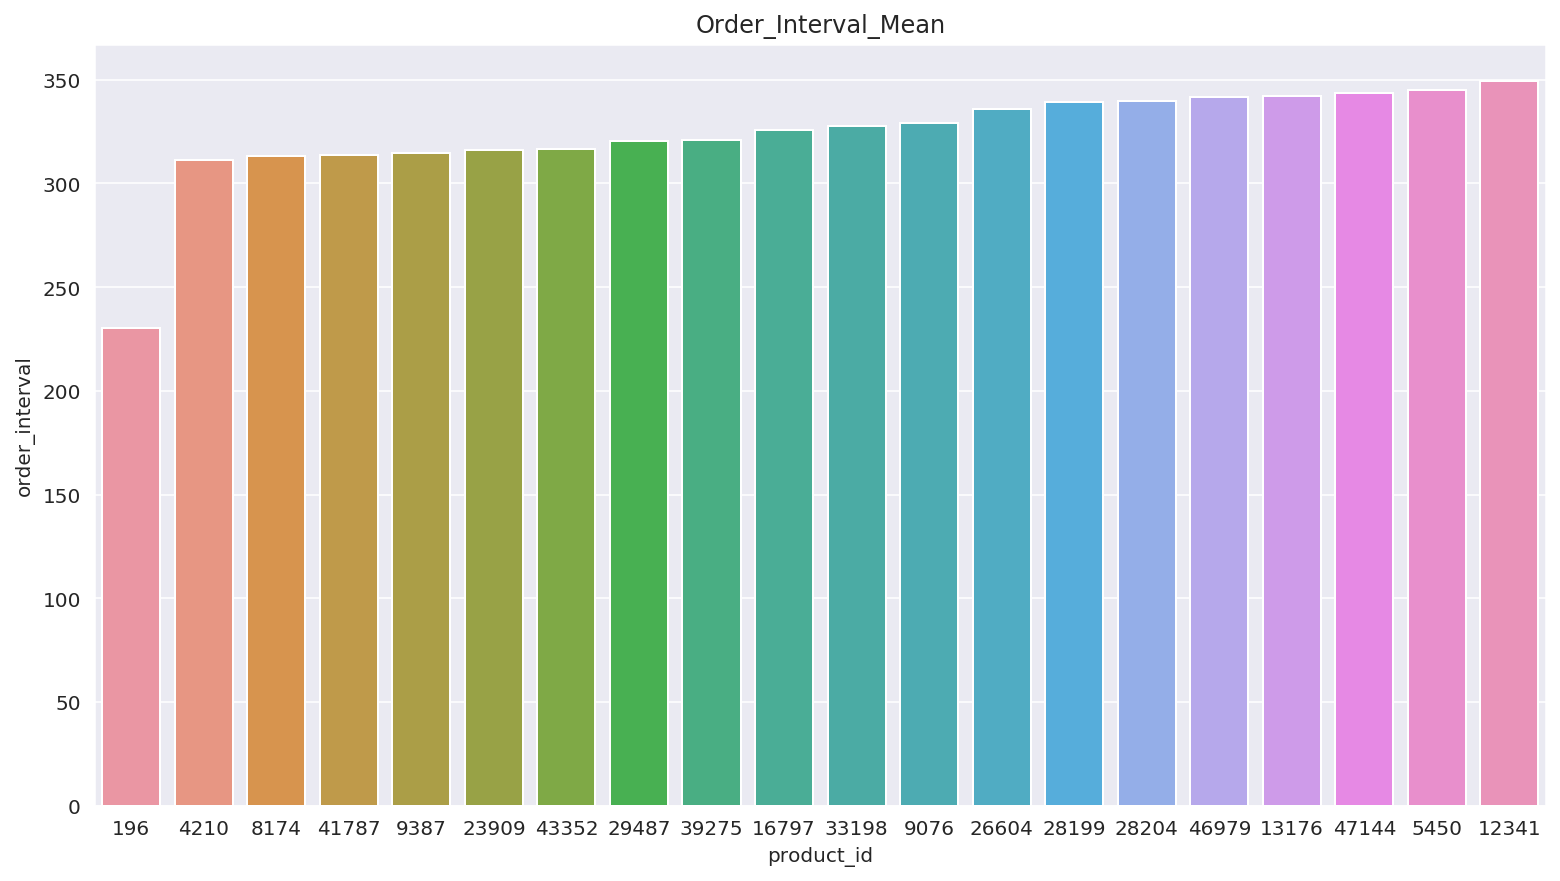

In [619]:
#상품별 재구매에 걸리는 평균 기간
df_test_x_past = test_x_past[['product_id','order_interval']]
df_test_x_past['product_id'] = df_test_x_past['product_id'].astype('string')
df_test_x_past = df_test_x_past.groupby('product_id',as_index=False).mean().sort_values(by='order_interval',ascending=True,ignore_index = True)
plt.figure(figsize=[13,7])
#재구매 평균기간 상위 20개  추출
p = sns.barplot(data=df_test_x_past.head(20),x='product_id',y='order_interval')
p.set_title('Order_Interval_Mean')
#재구매 평균 구매기간이 짧은 상품일수록 자주 구매할 확률이 올라간다.
#order_interval_ratio 변수를 생성하여 예측 모델의 변수로 활용 

In [620]:
test_x_past_info = pd.merge(left = test_x_past, right = product_info, how = 'left', on = 'product_id')
test_x_past_info.head(10)

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,first_order,name,category_id,division_id,category_name,division_name
0,117004,186630,37,4,11,30.0,12,1,21709,0.0,Sparkling Lemon Water,115,7,water seltzer sparkling water,beverages
1,128658,186630,20,2,10,60.0,4,1,21709,0.0,Sparkling Lemon Water,115,7,water seltzer sparkling water,beverages
2,165882,186630,56,3,15,50.0,10,1,21709,0.0,Sparkling Lemon Water,115,7,water seltzer sparkling water,beverages
3,180165,186630,17,1,16,40.0,4,1,21709,0.0,Sparkling Lemon Water,115,7,water seltzer sparkling water,beverages
4,394948,186630,46,5,11,70.0,7,1,21709,0.0,Sparkling Lemon Water,115,7,water seltzer sparkling water,beverages
5,534086,186630,6,5,14,30.0,2,1,21709,0.0,Sparkling Lemon Water,115,7,water seltzer sparkling water,beverages
6,743121,186630,33,5,12,30.0,13,1,21709,0.0,Sparkling Lemon Water,115,7,water seltzer sparkling water,beverages
7,1057297,186630,43,1,16,50.0,9,1,21709,0.0,Sparkling Lemon Water,115,7,water seltzer sparkling water,beverages
8,1110452,186630,54,1,13,40.0,2,1,21709,0.0,Sparkling Lemon Water,115,7,water seltzer sparkling water,beverages
9,1180698,186630,31,4,11,30.0,2,1,21709,0.0,Sparkling Lemon Water,115,7,water seltzer sparkling water,beverages


In [621]:
#고객별 재구매 상품 비율
df_pd_reordered = pd.DataFrame(test_x_past_info.groupby(['cstno', 'name','product_id'])['is_reordered'].sum()) # 고객별, 상품별 재구매 횟수
df_cn_reordered = pd.DataFrame(test_x_past_info.groupby(['cstno'])['is_reordered'].sum()) # 고객별 재구매 횟수
df_pd_reordered.reset_index()
df_cn_reordered.reset_index()

df_pd_reordered['is_reordered_ratio'] = df_pd_reordered['is_reordered'] / df_cn_reordered['is_reordered']# 고객별 상품에 대한 재구매 비율
df_pd_reordered = df_pd_reordered.reset_index().sort_values(by='is_reordered_ratio',ascending=False,ignore_index = True) # 내림차순으로 정렬

In [622]:
df_order_cnt = test_x_past[['order_id','cstno','order_number','add_order']]

In [623]:
#한번 주문할때 고객의 주문횟수
order_cnt = df_order_cnt.groupby(['order_id', 'cstno'])['add_order'].count()
order_cnt = order_cnt.reset_index()
order_cnt.rename(columns = {'add_order':'order_cnt'},inplace=True)
order_cnt

,order_id,cstno,order_cnt
0,1000,49841,1
1,1000033,203670,3
2,1000073,47257,1
3,100013,203670,3
4,1000167,148007,1
...,...,...,...
156684,999914,52009,1
156685,999936,121383,10
156686,999956,54418,4
156687,999963,63992,3


In [624]:
#고객의 평균 주문횟수
order_mean = order_cnt.groupby(['cstno'])['order_cnt'].mean()
order_mean = order_mean.reset_index()
order_mean.rename(columns = {'order_cnt':'order_mean'},inplace=True)
order_mean

,cstno,order_mean
0,63,3.228571
1,142,3.292683
2,173,3.081081
3,236,1.918919
4,280,3.658537
...,...,...
4136,205945,5.725000
4137,206083,3.583333
4138,206117,3.125000
4139,206174,2.463415


In [625]:
test_x_past = pd.merge(left = test_x_past, right = order_cnt, how = 'left', on = ['order_id','cstno'])
test_x_past = pd.merge(left = test_x_past, right = order_mean, how = 'left', on = ['cstno'])

In [626]:
test_x_past

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,first_order,order_cnt,order_mean
0,117004,186630,37,4,11,30.0,12,1,21709,0.0,3,2.794118
1,128658,186630,20,2,10,60.0,4,1,21709,0.0,3,2.794118
2,165882,186630,56,3,15,50.0,10,1,21709,0.0,3,2.794118
3,180165,186630,17,1,16,40.0,4,1,21709,0.0,2,2.794118
4,394948,186630,46,5,11,70.0,7,1,21709,0.0,3,2.794118
...,...,...,...,...,...,...,...,...,...,...,...,...
541917,2672845,119134,39,1,14,1070.0,4,1,24852,0.0,2,2.000000
541918,2731678,119134,38,5,14,30.0,4,1,24852,0.0,5,2.000000
541919,2860406,119134,9,5,9,80.0,1,1,24852,0.0,2,2.000000
541920,3252013,119134,4,5,10,70.0,2,1,24852,0.0,5,2.000000


In [627]:
cluster_set = pd.pivot_table(data= test_x_past, index = ['cstno'], values = ['first_order','order_interval','order_cnt','order_mean']
                              ,aggfunc='mean').reset_index()

In [628]:
dtot = cluster_set.drop('cstno',axis=1)

In [629]:
sc = StandardScaler()
sc_clust = sc.fit_transform(dtot)
sc_clust = pd.DataFrame(sc_clust)

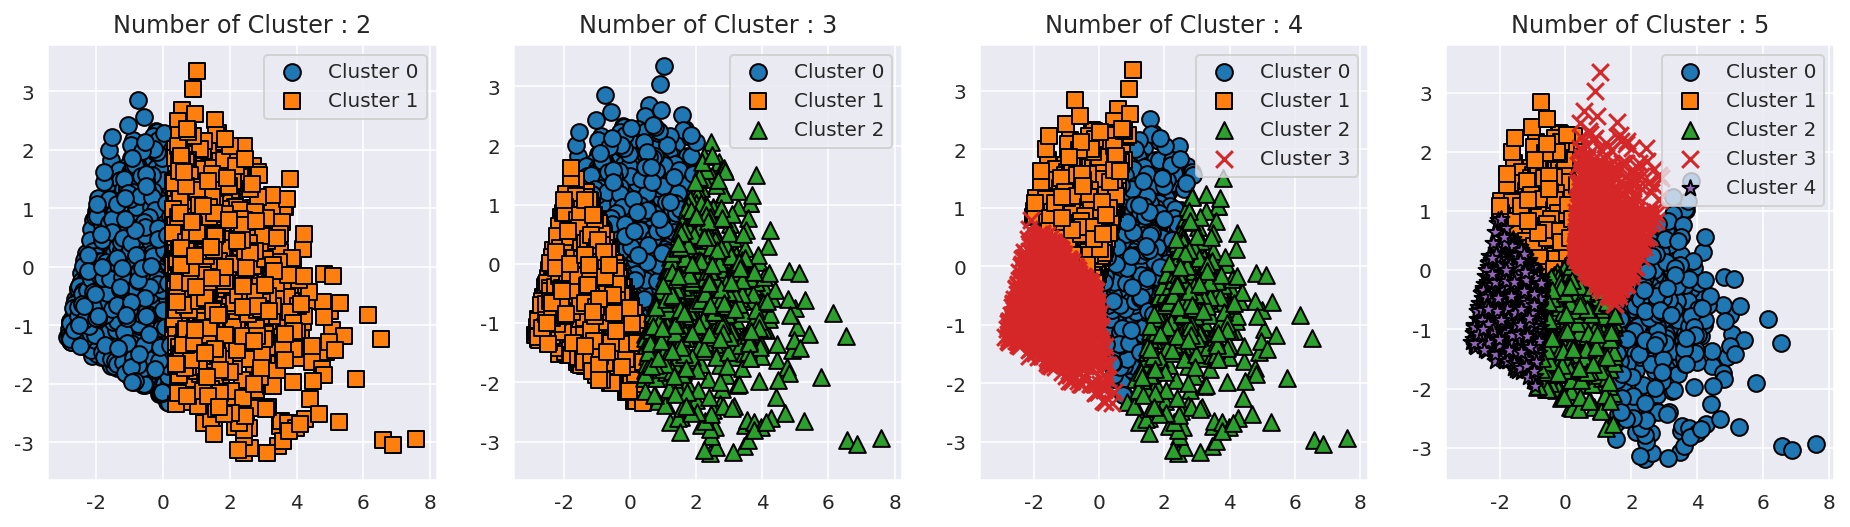

In [630]:
#군집 2,3,4,5, 에대한 시각화 표현
visualize_kmeans_plot_multi([2,3,4,5],sc_clust)


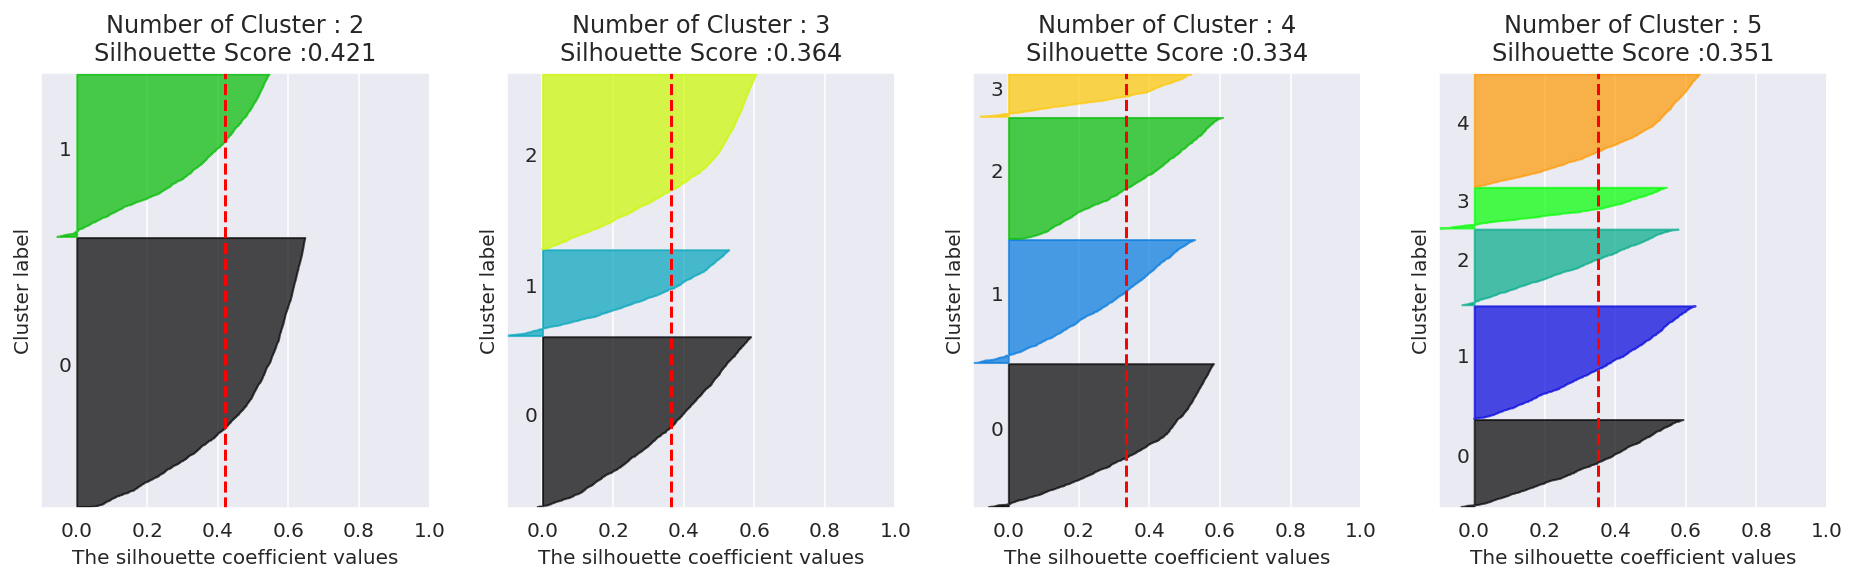

In [631]:
#최적의 군집을 찾기위한 실루엣 검증 (높을수록 좋은 군집)
visualize_silhouette([2,3,4,5],sc_clust)

In [632]:
model=KMeans(n_clusters=2,max_iter=150,init='k-means++')
model.fit(sc_clust)
cluster_set['cluster']=model.fit_predict(sc_clust)
cluster_set = cluster_set.drop(labels=['order_cnt','order_mean','first_order','order_interval'], axis = 1)
test_x_past = pd.merge(left = test_x_past ,right = cluster_set, how = 'left', on = ['cstno'])

In [633]:
test_x_current = pd.merge(left = test_x_current, right = cluster_set, how = 'left', on = ['cstno'])

In [634]:
#필요 컬럼 정의
col1 = ['week_day','order_hour','order_interval','add_order','is_reordered','cluster'] #  cstno 제외 전처리 
col2 = ['cstno', 'week_day','order_hour','order_interval','add_order','is_reordered','cluster'] # 모든 변수 포함 전처리


In [635]:
#test2 (모든 변수를 활용하고 weekday를  가변수로 변환)
x_train2 = test_x_past[col2]
y_train2 = test_x_past['product_id']
x_test2 = test_x_current[col2] 

In [636]:
#week_day를  가변수로 변환
x_train2 = pd.get_dummies(x_train2, columns=['week_day'])
x_test2 = pd.get_dummies(x_test2, columns=['week_day'])


In [637]:
#군집을를  가변수로 변환
x_train2 = pd.get_dummies(x_train2, columns=['cluster'])
x_test2 = pd.get_dummies(x_test2, columns=['cluster'])

In [638]:
# 평균 주무간격에 비해 얼마나 자주 상품을 주문하는지에 대한 변수 생성
x_train2['order_interval_ratio'] = x_train2['order_interval'] / x_train2['order_interval'].mean()
x_test2['order_interval_ratio'] = x_test2['order_interval'] / x_train2['order_interval'].mean()

In [639]:
#test2 shap
x_train2.shape, y_train2.shape, x_test2.shape 

((541922, 15), (541922,), (16126, 15))

In [641]:
clf_xgb = xgb.XGBClassifier(objective = 'multi:softprob',missing = 0, 
                            scale_pos_weight = 3,  max_depth = 5, 
                            learn_rate = 0.1, n_estimator=2) 

In [642]:
#test2을 모델에 fit함 모든변수를 포함하여 진행하였으며, week_day 변수를 가변수로 변환
clf_xgb.fit(x_train2,
            y_train2,
            eval_metric='merror',
             verbose=True)


[16:44:40] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate", "n_estimator", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learn_rate=0.1,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=0, monotone_constraints='()',
              n_estimator=2, n_estimators=100, n_jobs=48, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3, subsample=1,
              tree_method='exact', validate_parameters=1, ...)

In [643]:
#예측 실행
y_pred = clf_xgb.predict(x_test2)

In [644]:
y_pred

array(['21616', '24852', '27086', ..., '24852', '13176', '5077'],
      dtype=object)

In [645]:
df_y_pred=pd.DataFrame(y_pred)

In [647]:
df_y_pred.columns=['product_id']

In [648]:
df_y_pred

,product_id
0,21616
1,24852
2,27086
3,22935
4,13176
...,...
16121,13176
16122,13176
16123,24852
16124,13176


In [664]:
df_y_pred.to_csv('./test_y.csv',index=False)